<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Watson/project_3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [5]:
# Load the dataset
data_path = '/content/drive/MyDrive/disaster_data.pkl'
df = pd.read_pickle(data_path)
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.42352941 0.3372549 0.31764706], [0.4078...","Frank Island fire in YNP. #yellowstone , #yell...",fire,fire,damage
5297,"[[[[0.17647059 0.23137255 0.29411765], [0.2078...",ایران سوگوار کرمانشاهش شد.\n😢😢\n#کرمانشاه\nThe...,earthquake,earthquake,damage
1121,"[[[[0.10980392 0.10980392 0.10980392], [0.1098...","ACT OF PURE EVIL, this was terror attack PERIO...",war,war,damage
561,"[[[[0.24705882 0.43921569 0.23529412], [0.2196...",#rain #landslide,landslide,landslide,damage
1188,"[[[[0.88627451 0.80392157 0.7372549 ], [0.8901...",post-pizza party 🍕🔥🍕🔥🍕🔥🍕🔥🍕🔥 #sponcon #ad,non-damage,non-damage,non-damage


In [6]:
df['label_3'] = df['label_3'].map({'non-damage': 0, 'damage': 1})
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.42352941 0.3372549 0.31764706], [0.4078...","Frank Island fire in YNP. #yellowstone , #yell...",fire,fire,1
5297,"[[[[0.17647059 0.23137255 0.29411765], [0.2078...",ایران سوگوار کرمانشاهش شد.\n😢😢\n#کرمانشاه\nThe...,earthquake,earthquake,1
1121,"[[[[0.10980392 0.10980392 0.10980392], [0.1098...","ACT OF PURE EVIL, this was terror attack PERIO...",war,war,1
561,"[[[[0.24705882 0.43921569 0.23529412], [0.2196...",#rain #landslide,landslide,landslide,1
1188,"[[[[0.88627451 0.80392157 0.7372549 ], [0.8901...",post-pizza party 🍕🔥🍕🔥🍕🔥🍕🔥🍕🔥 #sponcon #ad,non-damage,non-damage,0


In [7]:
# Separate the features (images) and labels
X = np.stack(df['image'].values)  # Convert list of images to numpy array
Y = df['label_3'].values

In [8]:
# Check and print the shape of the input data
print(f"Original shape of X: {X.shape}")

# Handle cases based on the input shape
if len(X.shape) == 4 and X.shape[1] == 1:
    # If the shape is (batch_size, 1, height, width), transpose to (batch_size, height, width, 1)
    print("Transposing (batch_size, 1, height, width) -> (batch_size, height, width, 1)")
    X = np.transpose(X, (0, 2, 3, 1))
elif len(X.shape) == 3:
    # If the shape is (batch_size, height, width), expand to (batch_size, height, width, 1)
    print("Expanding dimensions to (batch_size, height, width, 1)")
    X = np.expand_dims(X, axis=-1)
else:
    # If shape is already correct (batch_size, height, width, channels), do nothing
    print("No changes needed. Input shape is correct.")

# Print the final shape for verification
print(f"Final shape of X: {X.shape}")  # Should be (batch_size, 250, 250, channels)


Original shape of X: (1000, 1, 250, 250, 3)
No changes needed. Input shape is correct.
Final shape of X: (1000, 1, 250, 250, 3)


In [9]:
X = X / 255.0


In [10]:
# Train-test split (80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
# Convert labels to categorical (binary classification: 0 or 1)
Y_train = to_categorical(Y_train, 2)
Y_test = to_categorical(Y_test, 2)

In [20]:
# Build the CNN model
model = Sequential()

# First convolutional layer with correct input shape for RGB images
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(250, 250, 3)))  # For RGB images

# If your images are grayscale, use this instead:
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(250, 250, 1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Add additional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Add fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# Output layer for binary classification
model.add(Dense(2, activation='softmax'))  # Two output neurons for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to confirm the input shape is correct
model.summary()

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 250, 250, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,766,626 (60.14 MB)

 Trainable params: 15,766,626 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.5080 - loss: 0.6954 - val_accuracy: 0.4650 - val_loss: 0.6939
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.5165 - loss: 0.6930 - val_accuracy: 0.4650 - val_loss: 0.6958
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5160 - loss: 0.6934 - val_accuracy: 0.4650 - val_loss: 0.6938
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.5350 - loss: 0.6925 - val_accuracy: 0.4650 - val_loss: 0.6950
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.4917 - loss: 0.6942 - val_accuracy: 0.4650 - val_loss: 0.6937
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.4894 - loss: 0.6934 - val_accuracy: 0.4650 - val_loss: 0.6937
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.4973 - loss: 0.6932 - val_accuracy: 0.4650 - val_loss: 0.6938
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5073 - loss: 0.6929 - val_accuracy: 0.4650 - va

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 - 10s - 1s/step - accuracy: 0.4650 - loss: 0.6939
Test Accuracy: 46.50%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


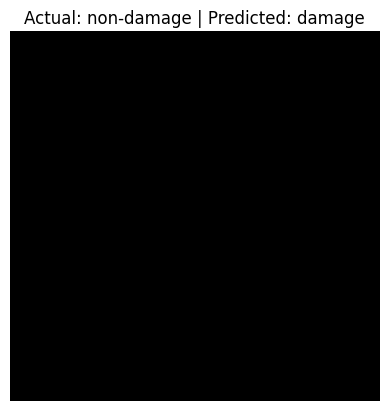

In [30]:
# Randomly select an image from the test set
random_index = random.randint(0, X_test.shape[0] - 1)
random_image = X_test[random_index]
actual_label = np.argmax(Y_test[random_index])

# Make a prediction
prediction = model.predict(np.expand_dims(random_image, axis=0))
predicted_label = np.argmax(prediction)

# Map labels to human-readable form
labels = {0: 'non-damage', 1: 'damage'}
actual_label_text = labels[actual_label]
predicted_label_text = labels[predicted_label]

# Display the random image with actual and predicted labels
plt.imshow(random_image)
plt.title(f'Actual: {actual_label_text} | Predicted: {predicted_label_text}')
plt.axis('off')
plt.show()


In [ ]:
# import pickle
# #Load the data from pkl files
# def load_data_from_pkl(pkl_filename):
#     with open(pkl_filename, 'rb') as f:
#         sample_df = pickle.load(f)
#     return sample_df

# df = load_data_from_pkl('/content/drive/MyDrive/disaster_data.pkl')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


# Preprocessing

In [ ]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# main_folder = "/content/drive/MyDrive/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# # images = np.array([np.array(image) for image in images])
# type(images)

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                    })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',

#                                    })

In [ ]:
df.head()

KeyboardInterrupt: 

In [ ]:
df['label_3'].value_counts()

In [ ]:
# sample_df = df.sample(n=1000, random_state=42)
# sample_df.info()

In [ ]:
# sample_df['label_3'].value_counts()

In [ ]:
df.head()

#Label and Split Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [ ]:
df.head()

,image,text,label,label_2,label_3
4436,"[[[[0.42352941 0.3372549 0.31764706], [0.4078...","Frank Island fire in YNP. #yellowstone , #yell...",fire,fire,damage
5297,"[[[[0.17647059 0.23137255 0.29411765], [0.2078...",ایران سوگوار کرمانشاهش شد.\n😢😢\n#کرمانشاه\nThe...,earthquake,earthquake,damage
1121,"[[[[0.10980392 0.10980392 0.10980392], [0.1098...","ACT OF PURE EVIL, this was terror attack PERIO...",war,war,damage
561,"[[[[0.24705882 0.43921569 0.23529412], [0.2196...",#rain #landslide,landslide,landslide,damage
1188,"[[[[0.88627451 0.80392157 0.7372549 ], [0.8901...",post-pizza party 🍕🔥🍕🔥🍕🔥🍕🔥🍕🔥 #sponcon #ad,non-damage,non-damage,non-damage


In [ ]:
X_image = df['image']
X_text = df['text']
y = df['label_3']

In [ ]:
new_X_image = []
for row in X_image:
    for image in row:
        new_X_image.append(image)

new_X_image[0]

X_image = [np.array(img).astype(np.float32) for img in new_X_image]

In [ ]:
resized_X_image = []

for img in X_image:
    if img.shape != (250, 250, 3):

        resized_img = np.resize(img, (250, 250, 3))

        resized_X_image.append(resized_img)
    else:

        resized_X_image.append(img)

X_image = np.array(resized_X_image)

In [ ]:
print(X_image.shape)
print(X_image[0].shape)

(1000, 250, 250, 3)
(250, 250, 3)


In [ ]:
y = y.replace({'damage': 1, 'non-damage': 0})

<ipython-input-11-29e6a47d55c9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'damage': 1, 'non-damage': 0})


In [ ]:
X_train_image, X_test_image, X_train_text, X_test_text, y_train, y_test = train_test_split(X_image, X_text, y, test_size=0.2, random_state=42)


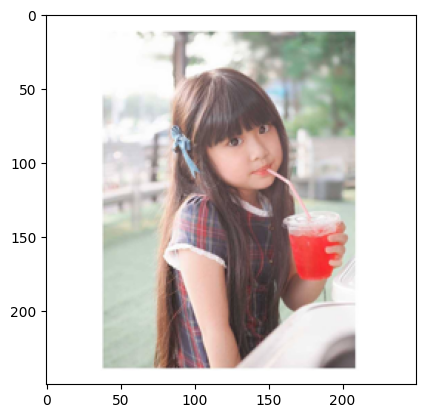

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((X_train_image[55]*255).astype(np.uint8))

# Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()
# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# Add fully connected layers
model.add(Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.03)))  # L2 regularization
model.add(Dropout(0.5))  # Optional dropout for regularization
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(32, activation='leaky_relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 238144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,241,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,266,945 (58.24 MB)

 Trainable params: 15,266,945 (58.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2) # Convert y_train to one-hot encoded format
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=2) # Convert y_test as well for consistency


In [ ]:
history = model.fit(X_train_image,
                    y_train,
                    epochs=10,
                    batch_size=32
                    )

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.4396 - loss: 3.9722
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.5195 - loss: 1.1898
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5567 - loss: 0.7846
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.5052 - loss: 0.7208
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5000 - loss: 0.7033
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.5028 - loss: 0.7073
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5222 - loss: 0.6978
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5222 - loss: 0.7036
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5122 - loss: 0.7259
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.4965 - loss: 0.7237


In [ ]:
model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 994ms/step - accuracy: 0.4330 - loss: 0.7066


[0.7045252323150635, 0.4650000035762787]

In [ ]:
predictions = model.predict(X_test_image)

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [ ]:
def create_cnn_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

cnn_model = create_cnn_model()

# # Extract features from images
# image_features = cnn_model.predict(images)

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model.fit(X_train_image, y_train, epochs=10, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 218s 8s/step - accuracy: 0.5119 - loss: 0.7546
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 271s 9s/step - accuracy: 0.5330 - loss: 0.6932
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 255s 8s/step - accuracy: 0.5393 - loss: 0.6852
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.6082 - loss: 0.6695
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - accuracy: 0.6134 - loss: 0.6580
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.6072 - loss: 0.6654
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.5873 - loss: 0.6651
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.5864 - loss: 0.6631
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.5438 - loss: 0.7070
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 0.5622 - loss: 0.6731


In [ ]:
def create_cnn_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(320, 320, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
    ])

    return model

cnn_model = create_cnn_model()

# Extract features from images
image_features = cnn_model.predict(images)
print(image_features.shape)  # Should return (num_images, 256) for example


OR


# CNN for image feature extraction
def create_cnn_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce dimensions
    x = Dense(256, activation='relu')(x)
    return base_model.input, x

image_input_shape = (224, 224, 3)
image_input, image_features = create_cnn_model(image_input_shape)

# LSTM for text processing
def create_lstm_model(vocab_size, embedding_dim, sequence_length):
    text_input = Input(shape=(sequence_length,))
    x = Embedding(vocab_size, embedding_dim, input_length=sequence_length)(text_input)
    x = LSTM(128)(x)
    return text_input, x

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
sequence_length = max_sequence_length

text_input, text_features = create_lstm_model(vocab_size, embedding_dim, sequence_length)

# Combine image features and text features
combined_features = Concatenate()([image_features, text_features])
combined_output = Dense(128, activation='relu')(combined_features)
final_output = Dense(1, activation='sigmoid')(combined_output)  # Binary classification

# Build the complete model
model = Model(inputs=[image_input, text_input], outputs=final_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


NameError: name 'images' is not defined

In [ ]:
# Assuming `images` is a numpy array of image data
# Assuming `texts` is a list of raw text corresponding to the images

# Tokenize and pad the text data
# tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)
# max_sequence_length = 100  # Define max sequence length
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# OR

# Using GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

def tokenize_texts(texts):
    return tokenizer(texts, return_tensors='tf', padding=True, truncation=True, clean_up_tokenization_spaces=Fa

# Tokenize the text data
tokenized_texts = tokenize_texts(texts)

# Example disaster reports (this could be loaded from your dataset)
sample_reports = ["Flood in Texas causes widespread damage.",
                  "Earthquake in Japan leads to massive destruction."]
tokenized_reports = tokenize_texts(sample_reports)

# Assuming `labels` is a numpy array containing the target labels for the task (e.g., 0 and 1 for binary classification)


Streaming output truncated to the last 5000 lines.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.


In [ ]:
# Split the data into training and test sets
image_train, image_test, text_train, text_test, y_train, y_test = train_test_split(
    images, padded_sequences, labels, test_size=0.2, random_state=42)

print(f"Training set: {image_train.shape}, {text_train.shape}, {y_train.shape}")
print(f"Test set: {image_test.shape}, {text_test.shape}, {y_test.shape}")

In [ ]:
def create_lstm_model(image_feature_size, vocab_size, seq_length):
    image_input = layers.Input(shape=(image_feature_size,))
    text_input = layers.Input(shape=(seq_length,))

    # Combine Image and Text features
    x = layers.Concatenate()([image_input, text_input])
    x = layers.Embedding(vocab_size, 256)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)

    model = models.Model(inputs=[image_input, text_input], outputs=x)
    return model

vocab_size = len(tokenizer)  # GPT tokenizer vocab size
seq_length = tokenized_reports['input_ids'].shape[1]  # Max sequence length
lstm_model = create_lstm_model(256, vocab_size, seq_length)

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Fine-tune GPT-2 model
def fine_tune_gpt2(image_features, texts, tokenizer):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
    outputs = gpt2_model(inputs['input_ids'], labels=inputs['input_ids'])
    loss = outputs.loss
    logits = outputs.logits

    # Train your model on this loss
    return loss

# Example training loop
for epoch in range(10):
    loss = fine_tune_gpt2(image_features, sample_reports, tokenizer)
    print(f"Epoch {epoch+1}, Loss: {loss}")


In [ ]:
# Save the CNN + LSTM model or GPT-2 based model
lstm_model.save("disaster_report_model.h5")

# For GPT-2 (Hugging Face)
gpt2_model.save_pretrained("disaster_gpt2_model")
tokenizer.save_pretrained("disaster_gpt2_model_tokenizer")


# Creating Web Application

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from PIL import Image
import numpy as np

# Load the saved LSTM or GPT model
lstm_model = tf.keras.models.load_model('disaster_report_model.h5')

# If using GPT-2
gpt2_model = TFGPT2LMHeadModel.from_pretrained('disaster_gpt2_model')
tokenizer = GPT2Tokenizer.from_pretrained('disaster_gpt2_model_tokenizer')

app = Flask(__name__)

# Image preprocessing function
def preprocess_image(image, target_size=(224, 224)):
    image = Image.open(image)
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Report generation endpoint
@app.route('/generate_report', methods=['POST'])
def generate_report():
    file = request.files['image']

    # Preprocess the input image
    image = preprocess_image(file)

    # Extract features from the image using CNN
    image_features = lstm_model.predict(image)  # You may want to extract features only

    # Use the LSTM or GPT model to generate a report
    # If LSTM:
    # generated_report = lstm_model.predict(image_features)

    # If GPT-2:
    input_text = tokenizer.decode(image_features[0])  # Convert image features to text for GPT-2
    input_ids = tokenizer.encode(input_text, return_tensors="tf")
    generated_report = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1)

    report = tokenizer.decode(generated_report[0], skip_special_tokens=True)

    return jsonify({"report": report})

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
python app.py


In [ ]:
curl -X POST -F "image=@/path/to/disaster_image.jpg" http://127.0.0.1:5000/generate_report


In [ ]:
pip freeze > requirements.txt


In [ ]:
web: python app.py


In [ ]:
git init
heroku create
git add .
git commit -m "First commit"
git push heroku master
